# Time series forecasting project

In [2]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression, LogisticRegression   
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima

from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor

## 1. Data loading

### 1.1. Load

In [3]:
raw_data_df=sns.load_dataset('flights')

### 1.2. Inspect 

In [4]:
raw_data_df.info()

print(raw_data_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB
   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


### 1.3. Encode date feature

Pandas has many great tools to work with timeseries data - see the user guide article: '*[Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)*'. First thing to do is convert our string date feature(s) to a Datetime object.

In [5]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()



# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [6]:
timeseries_df

,dependent_var
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## 2. EDA

### 2.1. Baseline model performance

Let's set a quick performance baseline using a quick/easy linear regression model.

In [7]:

linear_model=LinearRegression()


x=np.array(range(len(timeseries_df))).reshape(-1, 1)
fit_result=linear_model.fit(x, timeseries_df['dependent_var'])
predictions=linear_model.predict(x)


timeseries_df['Linear model']=predictions


rmse=sqrt(mean_squared_error(timeseries_df['dependent_var'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 45.7


In [8]:
predictions = timeseries_df['dependent_var'].to_numpy()[1:]
true_values = timeseries_df['dependent_var'].to_numpy()[0:-1]

rmse=sqrt(mean_squared_error(true_values, predictions))
rmse


33.710408012832005

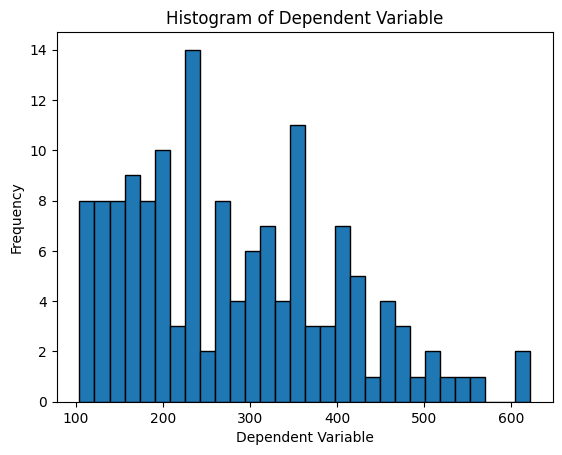

In [9]:
#want to graph histogram of dependent variable (# of passengers)

plt.title('Histogram of Dependent Variable')
plt.xlabel('Dependent Variable')
plt.ylabel('Frequency')
plt.hist(timeseries_df['dependent_var'], bins=30, edgecolor='black')
plt.show()

            dependent_var  Linear model
date                                   
1949-01-01            112     90.309962
1949-02-01            118     92.967146
1949-03-01            132     95.624330
1949-04-01            129     98.281513
1949-05-01            121    100.938697
...                   ...           ...
1960-08-01            606    459.658525
1960-09-01            508    462.315709
1960-10-01            461    464.972893
1960-11-01            390    467.630077
1960-12-01            432    470.287261

[144 rows x 2 columns]
       dependent_var  Linear model
count     144.000000    144.000000
mean      280.298611    280.298611
std       119.966317    110.839929
min       104.000000     90.309962
25%       180.000000    185.304286
50%       265.500000    280.298611
75%       360.500000    375.292936
max       622.000000    470.287261


<function matplotlib.pyplot.show(close=None, block=None)>

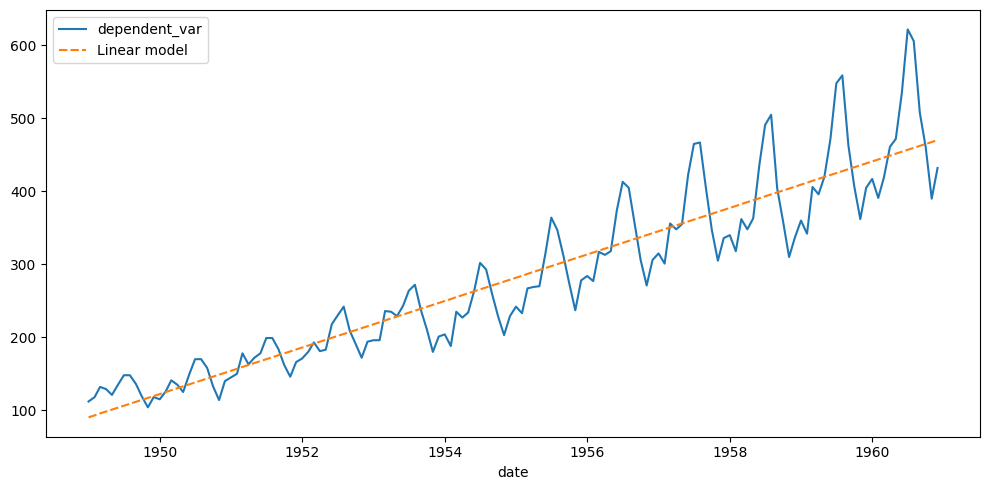

In [10]:
print(timeseries_df)
print(timeseries_df.describe())
fig, axis = plt.subplots(figsize = (10,5,))

sns.lineplot(data = timeseries_df)

plt.tight_layout()
plt.show

In [11]:


print(timeseries_df.isnull().sum())


dependent_var    0
Linear model     0
dtype: int64


In [12]:
if timeseries_df.isnull().sum().sum() == 0:
    print("✅ No missing values in the entire DataFrame.")
else:
    print("⚠️ There are missing values.")
    

✅ No missing values in the entire DataFrame.


In [13]:
# Take the difference across the datetime index
diff=np.diff(timeseries_df.index.to_numpy())

# Check that all of the differences are equal
equally_spaced=np.all(diff==diff[0])

print(f'Datetime axis is regular: {equally_spaced}\n')


Datetime axis is regular: False



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   Linear model   144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


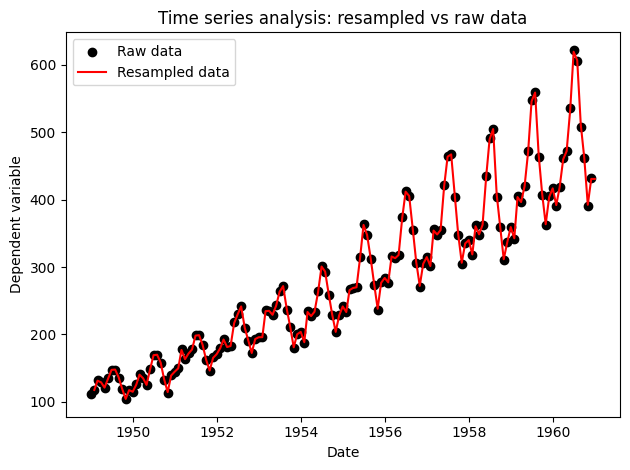

In [14]:

resampled_timeseries_df=timeseries_df.resample('D').interpolate()

# Then resample back up to months
resampled_timeseries_df=resampled_timeseries_df.resample('ME').interpolate()
resampled_timeseries_df.info()


plt.title('Time series analysis: resampled vs raw data')
plt.scatter(timeseries_df.index, timeseries_df['dependent_var'], label='Raw data', color='black')
plt.plot(resampled_timeseries_df.index, resampled_timeseries_df['dependent_var'], label='Resampled data', color='red')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



### 2.3.4. Seasonality

In [15]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(timeseries_df['dependent_var'])

Dickey-Fuller test results:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

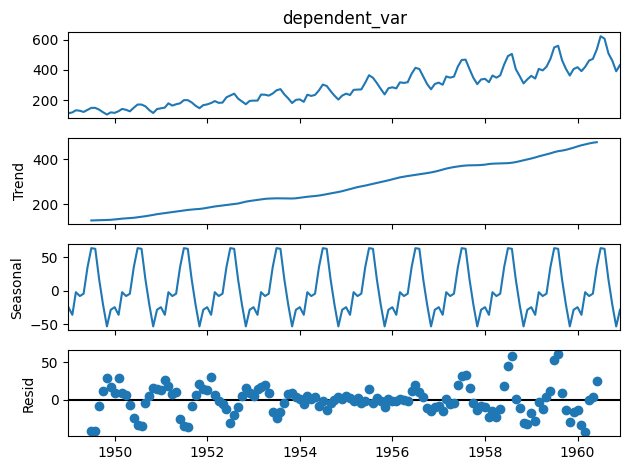

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Ensure data is sorted by date
timeseries_df = timeseries_df.sort_index()

# Perform decomposition
decomposition = seasonal_decompose(timeseries_df['dependent_var'], period=12)

# Plot the decomposition
decomposition.plot()
plt.tight_layout()
plt.show()

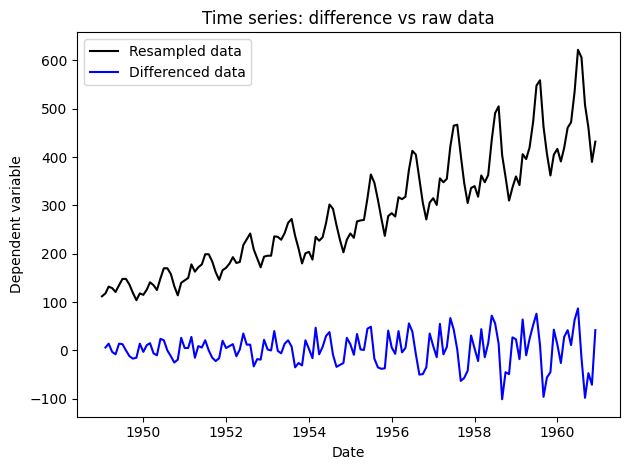

In [17]:
stationary_timeseries_df=timeseries_df['dependent_var'].diff().dropna()

plt.title('Time series: difference vs raw data')
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Resampled data', color='black')
plt.plot(stationary_timeseries_df.index, stationary_timeseries_df, label='Differenced data', color='blue')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3. Model training

In [18]:
from pmdarima import auto_arima
model = auto_arima(timeseries_df['dependent_var'], seasonal = True, trace = True, m = 12)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=1.00 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.08 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.12 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.46 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.14 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.42 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.10 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.32 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.30 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.55 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.03 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.03 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=1019.084, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.01 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=1023.666, Time=0.03 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(3,1,2)(0,1,0)[12]             : AIC=1021.083, Time=0.27 sec
 ARIMA(2,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.23 sec

Best model:  ARIMA(2,1,1)(0,1,0)[12]          
Total fit time: 4.325 seconds


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Sun, 30 Mar 2025   AIC                           1017.847
Time:                                     22:16:01   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.344      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.601      0.000      -1.057      -0.907
sigma2       129.3080     14.555      8.884      0.000     100.780     157.836
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
forecast = model.predict(10)
forecast

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


1961-01-01    445.634922
1961-02-01    420.394988
1961-03-01    449.198309
1961-04-01    491.839936
1961-05-01    503.394468
1961-06-01    566.862444
1961-07-01    654.260173
1961-08-01    638.597488
1961-09-01    540.883746
1961-10-01    494.126629
Freq: MS, dtype: float64

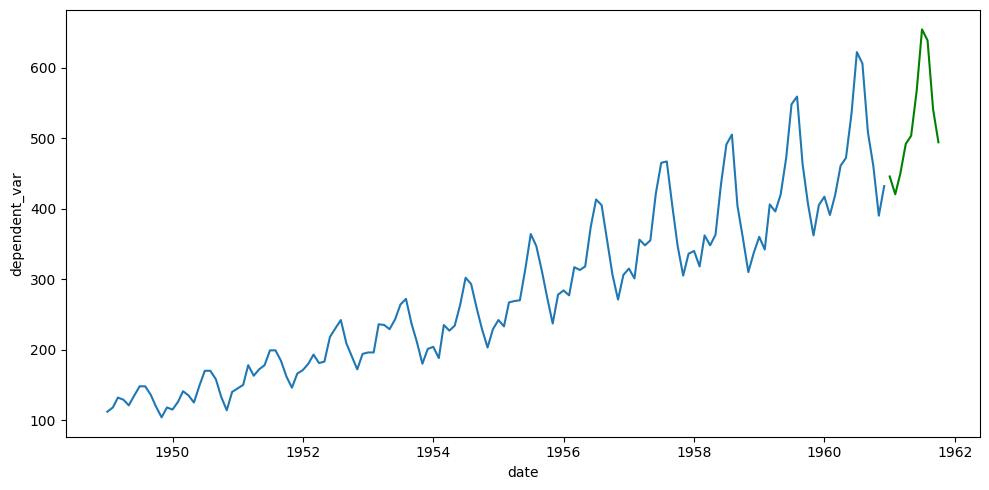

In [21]:


fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = timeseries_df['dependent_var'])
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()


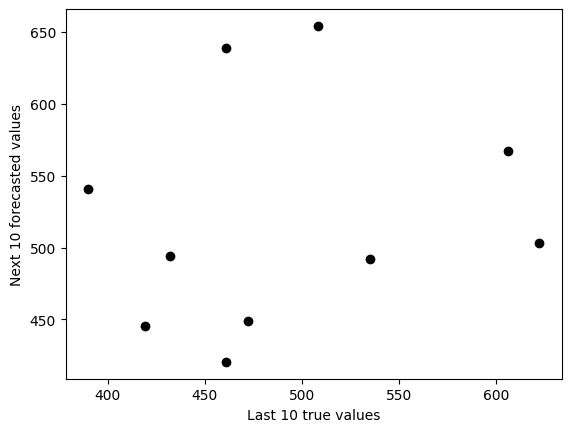

In [22]:
# Get the last 10 time points from the real data
true_data=timeseries_df['dependent_var'][-10:]

# Plot them against the predictions
plt.scatter(true_data, forecast, color='black')
plt.xlabel('Last 10 true values')
plt.ylabel('Next 10 forecasted values')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


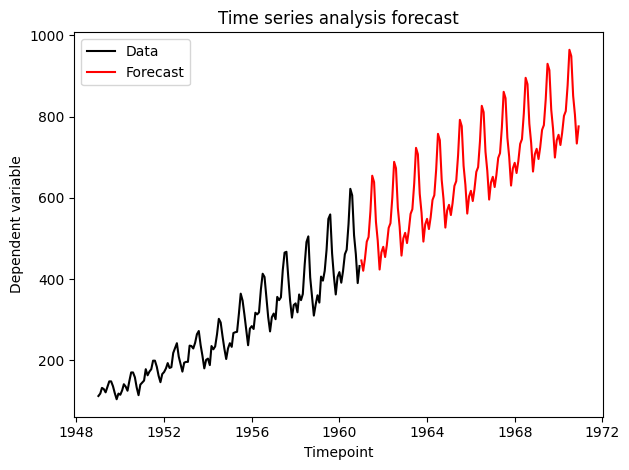

In [23]:
# Make predictions for the next 120 time points into the future
forecast=model.predict(120)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Timepoint')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon=6

# Set a model order, i.e. how many past data points should be used as input for prediction
model_order=36





# Make the test set one forecast horizon in length
testing_dataset_size=forecast_horizon

# Calculate how long the training set needs to be
training_set_size=len(timeseries_df) - testing_dataset_size

# Get the training and testing sets
training_data=timeseries_df[:training_set_size]
testing_data=timeseries_df[training_set_size:]

In [25]:
training_data.info()
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1949-01-01 to 1960-06-01
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  138 non-null    int64  
 1   Linear model   138 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 1960-07-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  6 non-null      int64  
 1   Linear model   6 non-null      float64
dtypes: float64(1), int64(1)
memory usage: 144.0 bytes


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=175.581, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=182.289, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=175.209, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=179.585, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=252.333, Time=0.00 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=173.687, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=175.213, Time=0.17 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=177.215, Time=0.08 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=174.616, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=175.058, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=177.710, Time=0.02 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=176.576, Time=0.09 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(1,0,0)(0,1,0)[12]             : AIC=178.963, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 1.127 seconds
Fold 1 RMSE: 10.5
Fold 1 predicted values: 1957-07-01    459.848002
1957-08-01    451.119137
1957-09-01    400.657986
1957-10-01    351.366218
1957-11-01    316.181618
1957-12-01    351.064822
Freq: MS, dtype: float64
Fold 1 validation values: [465 467 404 347 305 336]
Performing stepwise search to minimize aic


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=182.472, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=166.337, Time=0.11 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=251.057, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=171.817, Time=0.01 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.15 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.21 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=180.436, Time=0.08 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=168.328, Time=0.67 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=168.331, Time=0.99 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=171.987, Time=0.37 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=170.233, Time=0.06 sec

Best model:  ARIMA(1,0,0)(1,1,0)[12] intercept
Total fit time: 5.301 seconds
Fold 2 RMSE: 27.9
Fold 2 predicted values: 1958-01-01    347.846760
1958-02-01    329.733721
1958-03-01    395.208398
1958-04-01    384.811076
1958-05-01    393.354067
1958-06-01    467.876143
Freq: MS, dtype: float64
Fold 2 validation values: [340 318 362 348 363 435]
Performing stepwise search to minimize aic


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=204.897, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=176.431, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=243.100, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=176.315, Time=0.02 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=176.171, Time=0.07 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.53 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.48 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=206.172, Time=0.06 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=177.496, Time=0.11 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=177.755, Time=0.07 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,1,1)[12]             : AIC=175.767, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=176.821, Time=0.01 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,2)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=175.929, Time=0.04 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,2)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,1,1)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,1,1)[12]             : AIC=177.521, Time=0.07 sec
 ARIMA(1,0,1)(0,1,1)[12]             : AIC=177.586, Time=0.10 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec

Best model:  ARIMA(1,0,0)(0,1,1)[12]          
Total fit time: 4.653 seconds
Fold 3 RMSE: 11.7
Fold 3 predicted values: 1958-07-01    480.027553
1958-08-01    486.019778
1958-09-01    419.741349
1958-10-01    361.416552
1958-11-01    314.596274
1958-12-01    345.253518
Freq: MS, dtype: float64
Fold 3 validation values: [491 505 404 359 310 337]
Performing stepwise search to minimize aic


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=180.277, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=181.402, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=181.413, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=180.354, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=180.354, Time=0.06 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(0,1,0)(1,1,1)[12]             : AIC=182.354, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=181.572, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=181.639, Time=0.01 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=183.551, Time=0.01 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=181.988, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.655 seconds
Fold 4 RMSE: 39.5
Fold 4 predicted values: 1959-01-01    341.0
1959-02-01    319.0
1959-03-01    363.0
1959-04-01    349.0
1959-05-01    364.0
1959-06-01    436.0
Freq: MS, dtype: float64
Fold 4 validation values: [360 342 406 396 420 472]
Performing stepwise search to minimize aic


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=201.240, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=212.822, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=197.275, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=202.908, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=237.810, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=195.279, Time=0.01 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=197.276, Time=0.10 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=199.277, Time=0.12 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=197.261, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=197.269, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=201.612, Time=0.03 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=199.249, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=197.111, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 0.964 seconds
Fold 5 RMSE: 24.0
Fold 5 predicted values: 1959-07-01    526.448003
1959-08-01    539.270884
1959-09-01    437.378094
1959-10-01    391.700953
1959-11-01    342.187373
1959-12-01    368.797846
Freq: MS, dtype: float64
Fold 5 validation values: [548 559 463 407 362 405]
Performing stepwise search to minimize aic


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(2,1,2)(1,1,1)[12]             : AIC=197.443, Time=0.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=187.990, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=189.705, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=189.755, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=189.300, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=189.300, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=191.300, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=188.455, Time=0.01 sec


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(0,1,1)(0,1,0)[12]             : AIC=188.602, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=190.398, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=189.563, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.175 seconds
Fold 6 RMSE: 25.2
Fold 6 predicted values: 1960-01-01    428.0
1960-02-01    410.0
1960-03-01    474.0
1960-04-01    464.0
1960-05-01    488.0
1960-06-01    540.0
Freq: MS, dtype: float64
Fold 6 validation values: [417 391 419 461 472 535]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


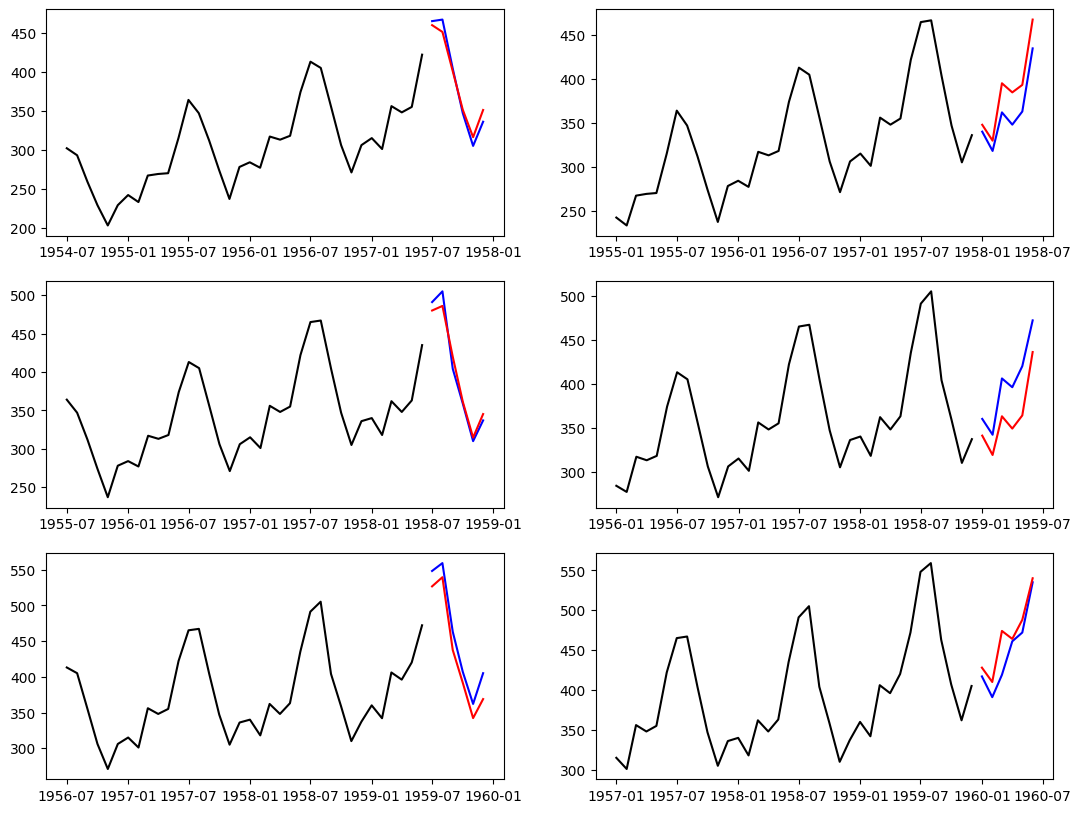

In [26]:
folds = 6
validation_rmse_results = []
predicted_values = []
validation_values = []


fig, axs=plt.subplots(3,2, figsize=(13,10)) 
axs=axs.flatten()


timeseries_splits = TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon) 

for i, timeseries_split in enumerate(timeseries_splits.split(training_data)):
    training_indices = timeseries_split[0]
    validation_indices = timeseries_split[1]
    
    fold_training_data = training_data.iloc[training_indices, :]
    fold_validation_data = training_data.iloc[validation_indices, :]
    
    # Fit the model
    timeseries_model = auto_arima(fold_training_data['dependent_var'], stationary = False, seasonal=True, m=12, trace=True, suppress_warnings=True)
    forecast = timeseries_model.predict(forecast_horizon)
    predicted_values.append(forecast)
    validation_values.append(fold_validation_data['dependent_var'])
    
    rmse = sqrt(mean_squared_error(fold_validation_data['dependent_var'], forecast))
    validation_rmse_results.append(rmse)
    print(f'Fold {i+1} RMSE: {rmse:.1f}')       
    print(f'Fold {i+1} predicted values: {forecast}')
    print(f'Fold {i+1} validation values: {fold_validation_data["dependent_var"].to_numpy()}')
    
    # Plot the results
    axs[i].plot(fold_training_data.index, fold_training_data['dependent_var'], label='Training data', color='black')
    axs[i].plot(fold_validation_data.index, fold_validation_data['dependent_var'], label='Validation data', color='blue')
    axs[i].plot(fold_validation_data.index, forecast, label='Forecast', color='red')        

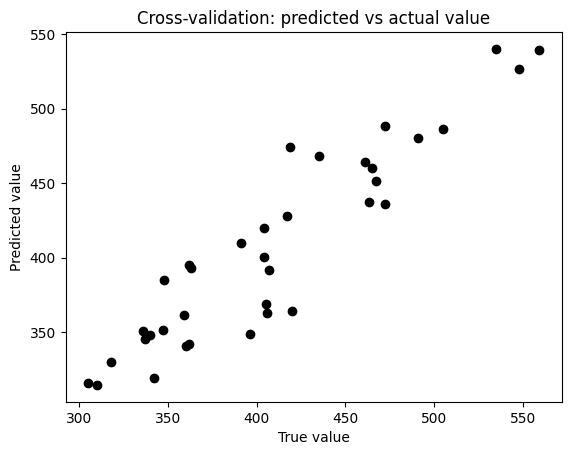

In [27]:
plt.title('Cross-validation: predicted vs actual value')
plt.scatter(validation_values, predicted_values, color='black')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [28]:
print(f'Cross-validation RMSE: {np.mean(validation_rmse_results):.1f}+/-{np.std(validation_rmse_results):.1f}')


Cross-validation RMSE: 23.1+/-9.9


In [29]:
linear_mdeol=LinearRegression()
x=np.array(range(len(training_data))).reshape(-1, 1)
fit_result=linear_model.fit(x, training_data['dependent_var'])

x_test = np.array(range(len(training_data), len(training_data) + forecast_horizon)).reshape(-1, 1)
predictions=linear_model.predict(x_test)

rmse = sqrt(mean_squared_error(testing_data['dependent_var'], predictions))
print(f'RMSE: {rmse:.1f}')
print(f'Predictions: {predictions}')
print(f'True values: {testing_data["dependent_var"].to_numpy()}')

RMSE: 101.4
Predictions: [450.14027293 452.72346109 455.30664925 457.88983742 460.47302558
 463.05621374]
True values: [622 606 508 461 390 432]


In [30]:
predictions = testing_data['dependent_var'].to_numpy()[1:]
true_values = testing_data['dependent_var'].to_numpy()[0:-1]
rmse = sqrt(mean_squared_error(true_values, predictions))

rmse_results['Cary forward model'] =rmse

print(f'Carry forward model: {rmse:.1f}')


Carry forward model: 61.4


In [31]:
y_pred

NameError: name 'y_pred' is not defined

In [92]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


# X = timeseries_df.drop(columns=['dependent_var'])
# y = timeseries_df['dependent_var']


tscv = TimeSeriesSplit(n_splits=4)

mse_scores = []

for train_index, test_index in tscv.split(timeseries_df.drop(columns=['dependent_var'])):
    X_train, X_test = timeseries_df.drop(columns=['dependent_var']).iloc[train_index], timeseries_df.drop(columns=['dependent_var']).iloc[test_index]
    y_train, y_test = timeseries_df['dependent_var'].iloc[train_index], timeseries_df['dependent_var'].iloc[test_index]
    
    model = LGBMRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f"Fold MSE: {mse:.4f}")
    
    

print(f"\nAverage MSE across folds: {np.mean(mse_scores):.4f}")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] Start training from score 145.294784
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightG

In [98]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor



# X = timeseries_df.drop(columns=['dependent_var'])
# y = timeseries_df['dependent_var']


tscv = TimeSeriesSplit(n_splits=4)

mse_scores = []

for train_index, test_index in tscv.split(timeseries_df.drop(columns=['dependent_var'])):
    X_train, X_test = timeseries_df.drop(columns=['dependent_var']).iloc[train_index], timeseries_df.drop(columns=['dependent_var']).iloc[test_index]
    y_train, y_test = timeseries_df['dependent_var'].iloc[train_index], timeseries_df['dependent_var'].iloc[test_index]
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f"Fold MSE: {mse:.4f}")
    
    

print(f"\nAverage MSE across folds: {np.mean(mse_scores):.4f}")

Fold MSE: 1379.6398
Fold MSE: 6177.5396
Fold MSE: 6463.0453
Fold MSE: 7051.4372

Average MSE across folds: 5267.9155


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


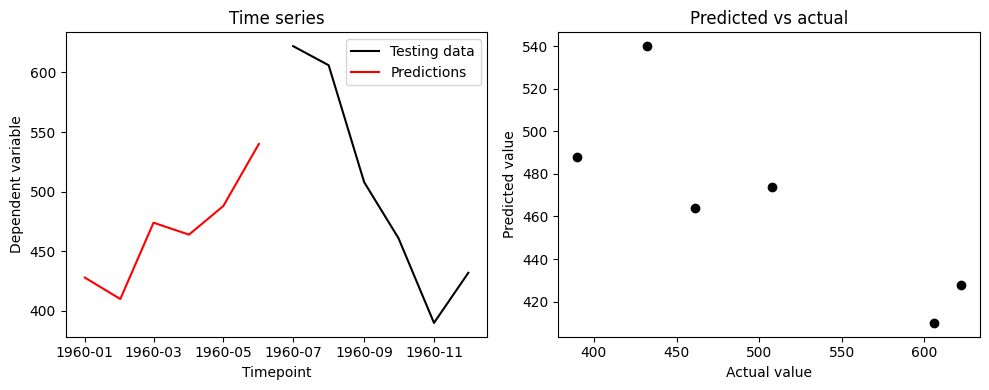

In [32]:
# Make predictions
forecast=timeseries_model.predict(forecast_horizon)

# Plot the result
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,4))

ax1.set_title('Time series')
ax1.plot(testing_data['dependent_var'], label='Testing data', color='black')
ax1.plot(forecast, label='Predictions', color='red')
ax1.set_xlabel('Timepoint')
ax1.set_ylabel('Dependent variable')
ax1.legend(loc='best')

ax2.set_title('Predicted vs actual')
ax2.scatter(testing_data['dependent_var'], forecast, color='black')
ax2.set_xlabel('Actual value')
ax2.set_ylabel('Predicted value')

plt.tight_layout()
plt.show()

In [33]:
# Calculate RMSE on test set
rmse=sqrt(mean_squared_error(testing_data['dependent_var'], forecast))
rmse_results['ARIMA test data']=rmse

print(f'Root mean square error:')

for experiment, rmse in rmse_results.items():
    print(f'  {experiment}: {rmse:.1f}')

Root mean square error:
  Linear model: 45.7
  Cary forward model: 61.4
  ARIMA test data: 128.1
